# Reducers de Estado


Relembrando a Importância dos "Reducers" de Estado em LangGraph

Os reducers de estado são fundamentais no LangGraph para controlar como o estado é atualizado ao longo do fluxo de execução dos nós. Em grafos onde os nós podem ser executados em paralelo ou onde há ramificações, é comum que múltiplos nós tentem atualizar a mesma chave do estado simultaneamente. Sem um mecanismo adequado para combinar essas atualizações, poderíamos enfrentar conflitos ou perda de dados.

Os reducers especificam uma função de redução que define como combinar múltiplas atualizações em uma única chave de estado. Isso é especialmente importante em workflows agentivos (agentic-workflows), onde agentes autônomos podem operar simultaneamente, e suas interações e comunicações precisam ser gerenciadas de forma coerente.

Como os Reducers Ajudam na Construção de Agentic-Workflows

Resolução de Conflitos: Em ambientes onde múltiplos agentes estão atualizando o estado simultaneamente, os reducers garantem que essas atualizações sejam combinadas de maneira consistente, evitando conflitos.

Paralelismo Seguro: Permitem que nós sejam executados em paralelo sem se preocupar com a ordem de atualização do estado, pois os reducers cuidarão de combinar os resultados apropriadamente.

Flexibilidade na Manipulação de Estado: Ao permitir definir reducers personalizados, os desenvolvedores podem adaptar a lógica de combinação de estado às necessidades específicas do workflow.

Gestão de Mensagens: Em workflows onde agentes trocam mensagens, reducers como add_messages facilitam a acumulação e gerenciamento dessas mensagens no estado global.



## Visão Geral

Abordamos algumas maneiras diferentes de definir o esquema de estado do LangGraph, incluindo `TypedDict`, `Pydantic` ou `Dataclasses`.

## Objetivos

Agora, vamos nos aprofundar nos reducers, que especificam como as atualizações de estado são realizadas em chaves/canais específicos no esquema de estado.

In [33]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## Estado de sobrescrita padrão

Vamos usar um `TypedDict` como nosso "schema" de estado.

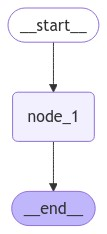

In [34]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Nó 1---")
    return {"foo": state['foo'] + 1}

# Construindo grafo
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Lógica
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Adicionando
graph = builder.compile()

# Visualizando
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
graph.invoke({"foo" : 1})

---Nó 1---


{'foo': 2}

Vamos analisar a atualização de estado, `return {"foo": state['foo'] + 1}`.

Como discutido anteriormente, por padrão, o LangGraph não conhece a maneira "preferencial" de atualizar o estado.

Então, ele simplesmente sobrescreverá o valor de `foo` em `node_1`:

```
return {"foo": state['foo'] + 1}
```
 
Se passarmos `{'foo': 1}` como entrada, o estado retornado pelo gráfico é `{'foo': 2}`.

## Ramificação

Vamos olhar para um caso onde nossos nós se ramificam.

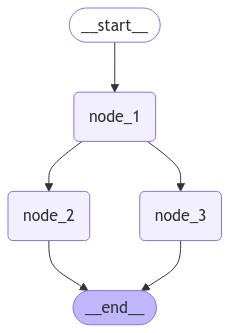

In [36]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Construir grafo
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logica
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Adicionar
graph = builder.compile()

# Visualizar
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.


Vemos um problema!

O Nó 1 se ramifica para os nós 2 e 3.

Os Nós 2 e 3 são executados em paralelo, o que significa que eles são executados na mesma etapa do grafo.

Ambos tentam sobrescrever o estado *dentro da mesma etapa*.

Isso é ambíguo para o grafo! Qual estado ele deve manter?

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) nos fornecem uma maneira geral de abordar esse problema.

Eles especificam como realizar atualizações.

Podemos usar o tipo `Annotated` para especificar uma função reducer.

Por exemplo, neste caso, vamos anexar o valor retornado de cada nó em vez de sobrescrevê-los.

Precisamos apenas de um reducer que possa realizar isso: `operator.add` é uma função do módulo operator embutido do Python.

Quando `operator.add` é aplicado a listas, ele realiza a concatenação de listas.

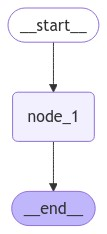

In [38]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Construir grafo
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logica #
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Adicionand
graph = builder.compile()

# Visualizando
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

Agora, nossa chave de estado `foo` é uma lista.

Esta função "reducer `operator.add` irá anexar atualizações de cada nó a esta lista.

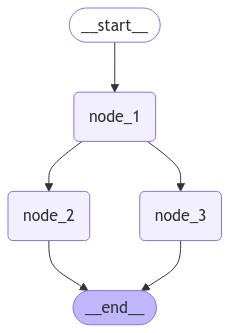

In [40]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Construir grafo
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logica
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Adicionar
graph = builder.compile()

# Visualizar
display(Image(graph.get_graph().draw_mermaid_png()))

Podemos ver que as atualizações nos nós 2 e 3 são realizadas simultaneamente porque estão na mesma etapa.


In [41]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

Agora, vamos ver o que acontece se passarmos `None` para `foo`.

Vemos um erro porque nosso reducer, `operator.add`, tenta concatenar `NoneType` passado como entrada para a lista em `node_1`. 


In [42]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## "Reducers" Customizados

Para abordar casos como este, [podemos também definir reducers personalizados](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state). 

Por exemplo, vamos definir a lógica de redução personalizada para combinar listas e lidar com casos onde qualquer um ou ambos dos inputs podem ser `None`.

In [43]:
def reduce_list(esquerda: list | None, direita: list | None) -> list:
    """Combina duas listas de forma segura, lidando com casos onde uma ou ambas as entradas podem ser None.

    Args:
        esquerda (list | None): A primeira lista a ser combinada, ou None.
        direita (list | None): A segunda lista a ser combinada, ou None.

    Returns:
        list: Uma nova lista contendo todos os elementos de ambas as listas de entrada.
              Se uma entrada for None, ela é tratada como uma lista vazia.
    """
    if not esquerda:
        esquerda = []
    if not direita:
        direita = []
    return esquerda + direita

class EstadoPadrao(TypedDict):
    foo: Annotated[list[int], add]

class EstadoRedutorPersonalizado(TypedDict):
    foo: Annotated[list[int], reduce_list]

No `node_1`, anexamos o valor 2.

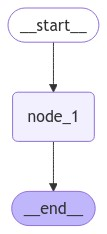

TypeError occurred: can only concatenate list (not "NoneType") to list


In [44]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Construindo  grafo
builder = StateGraph(EstadoPadrao)
builder.add_node("node_1", node_1)

# Logica
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Adicionando
graph = builder.compile()

# Visualizando
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Agora, vamos tentar com nosso reducer personalizado. Podemos ver que nenhum erro é lançado.

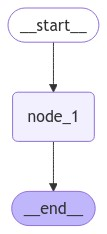

---Node 1---
{'foo': [2]}


In [45]:
# Construindo grafo
builder = StateGraph(EstadoRedutorPersonalizado)
builder.add_node("node_1", node_1)

# logica
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# AdicionaNDO
graph = builder.compile()

# Visualizando
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

No modulo 1, mostramos como usar um reducer interno, `add_messages`, para lidar com mensagens no estado.
 

Nos também mostramos que [`MessagesState` é um atalho útil se você quiser trabalhar com mensagens](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate). 

* `MessagesState` tem uma chave `messages` 
* `MessagesState` tem um reducer interno `add_messages` para esta chave
* E também tem um reducer interno `add_messages` para esta chave

Esses dois são equivalentes.

Vamos usar a classe `MessagesState` via `from langgraph.graph import MessagesState` para brevidade.


In [46]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Definindo um TypedDict customizado que inclui uma lista de mensagens com o reducer add_messages
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Usando MessagesState, que inclui a chave messages com o reducer add_messages
class ExtendedMessagesState(MessagesState):
    # Adicione qualquer chave necessária além de messages, que é pré-construído
    added_key_1: str
    added_key_2: str
    # etc

Vamos ver como usar o reducer `add_messages` para adicionar mensagens ao estado.

In [47]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Estado inicial
initial_messages = [AIMessage(content="ola! Como eu posso ajudar?", name="Model"),
                    HumanMessage(content=" Estou procurando informaçes sobre agentes de IA.", name="Anderson")
                   ]

# Nova mensagem para adicionar
new_message = AIMessage(content="Claro, eu posso ajudar com isso. O que voce esta procurando?", name="Model")

# Teste
add_messages(initial_messages , new_message)

[AIMessage(content='ola! Como eu posso ajudar?', additional_kwargs={}, response_metadata={}, name='Model', id='ba6b5d9a-23a2-4c26-9c5b-e9463e30f38a'),
 HumanMessage(content=' Estou procurando informaçes sobre agentes de IA.', additional_kwargs={}, response_metadata={}, name='Anderson', id='fcbeb477-9542-460a-9539-727a2af2ed33'),
 AIMessage(content='Claro, eu posso ajudar com isso. O que voce esta procurando?', additional_kwargs={}, response_metadata={}, name='Model', id='f55e4666-f616-4e12-ad0d-9349f9af8475')]

Entao nos vemos que `add_messages` nos permite anexar mensagens à chave `messages` em nosso estado.

### Reescrevendo 
Vamos mostrar algumas dicas úteis ao trabalhar com o reducer `add_messages`.

Se passarmos uma mensagem com o mesmo ID de uma existente em nossa lista `messages`, ela será sobrescrita!

In [48]:
# Estado inicial
initial_messages = [AIMessage(content="Ola! Como posso ajudar?", name="Model", id="1"),
                    HumanMessage(content="Estou procurando informações sobre agentes de IA.", name="Anderson", id="2")
                   ]

# Nova mensagem para adicionar
new_message = HumanMessage(content="Na verdade, quero saber espeficicamente sobre Agentic-Workflows", name="Anderson", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Ola! Como posso ajudar?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content='Na verdade, quero saber espeficicamente sobre Agentic-Workflows', additional_kwargs={}, response_metadata={}, name='Anderson', id='2')]

### Remocao

`add_messages` tambem [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). 

Para isso, simplesmente usamos [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) do `langchain_core`.

In [49]:
from langchain_core.messages import RemoveMessage

# Lista de mensagens
messages = [AIMessage("E ai, como vai?", name="Bot", id="1")]
messages.append(HumanMessage("Tudo bem, e com voce?", name="Anderson", id="2"))
messages.append(AIMessage("Entao, voce esta procurando informaçes sobre agentes de IA?", name="Bot", id="3"))
messages.append(HumanMessage("Sim, e tambem Agentic-Workflows. Alguma outra sugestao?", name="Anderson", id="4"))


# Isolando mensagens para deletar
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [50]:
add_messages(messages , delete_messages)

[AIMessage(content='Entao, voce esta procurando informaçes sobre agentes de IA?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Sim, e tambem Agentic-Workflows. Alguma outra sugestao?', additional_kwargs={}, response_metadata={}, name='Anderson', id='4')]

Nos podemos ver que as mensagens com IDs 1 e 2, conforme notado em `delete_messages`, sao removidas pelo reducer.

Nos veremos isso em pratica um pouco mais tarde.

# Mais um exemplo:

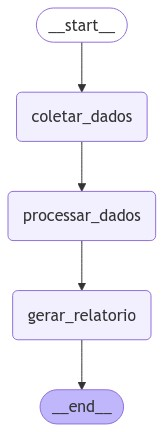

SCoras Academy: Coletando dados do usuário...
SCoras Academy: Processando dados...
SCoras Academy: Gerando relatório...

Mensagens acumuladas no estado:
Dados coletados
Dados processados
Relatório gerado


In [51]:
# Exemplo prático usando LangGraph e citando SCoras Academy

# Instalando as dependências necessárias
!pip install --quiet -U langchain_core langgraph

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from operator import add
from IPython.display import Image, display

# Definindo o esquema de estado com um reducer personalizado
class EstadoSCoras(TypedDict):
    mensagens: Annotated[list[str], add]

# Definindo os nós do grafo
def coletar_dados(state):
    print("SCoras Academy: Coletando dados do usuário...")
    return {"mensagens": ["Dados coletados"]}

def processar_dados(state):
    print("SCoras Academy: Processando dados...")
    return {"mensagens": ["Dados processados"]}

def gerar_relatorio(state):
    print("SCoras Academy: Gerando relatório...")
    return {"mensagens": ["Relatório gerado"]}

# Construindo o grafo
builder = StateGraph(EstadoSCoras)
builder.add_node("coletar_dados", coletar_dados)
builder.add_node("processar_dados", processar_dados)
builder.add_node("gerar_relatorio", gerar_relatorio)

# Definindo a lógica do grafo
builder.add_edge(START, "coletar_dados")
builder.add_edge("coletar_dados", "processar_dados")
builder.add_edge("processar_dados", "gerar_relatorio")
builder.add_edge("gerar_relatorio", END)

# Compilando o grafo
grafo = builder.compile()

# Visualizando o grafo
display(Image(grafo.get_graph().draw_mermaid_png()))

# Executando o grafo com estado inicial vazio
estado_inicial = {"mensagens": []}
resultado = grafo.invoke(estado_inicial)

# Exibindo o resultado final
print("\nMensagens acumuladas no estado:")
for mensagem in resultado["mensagens"]:
    print(mensagem)


## Explicação do Código

Neste exemplo, estamos construindo um workflow simples que representa uma sequência de passos em um curso da Scoras Academy sobre LangGraph:

Coletar Dados: Simula a coleta de dados do usuário.
Processar Dados: Processa os dados coletados.
Gerar Relatório: Gera um relatório baseado nos dados processados.
Utilizamos um reducer (operator.add) para a chave mensagens no estado, permitindo que cada nó adicione suas mensagens ao estado global sem sobrescrever as mensagens anteriores. Isso demonstra como os reducers facilitam o acúmulo de informações em um fluxo de trabalho.

## Conclusão

Os reducers de estado são essenciais para garantir que os workflows construídos com LangGraph sejam robustos e escaláveis, especialmente em cenários complexos como os agentic-workflows. Ao entender e utilizar os reducers de forma eficaz, podemos desenvolver aplicações mais confiáveis e eficientes.

SCoras Academy está comprometida em ensinar essas e outras técnicas avançadas de LangGraph, capacitando desenvolvedores a criar soluções inovadoras no campo da inteligência artificial e fluxos de trabalho automatizados.